In [1]:
#libraries for plotting
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#libraries for data cleaning and tyding
import pandas as pd
import numpy as np

#Libraries for model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

# TO DO:
### - Change NON-SCORE reduced_results and combine with punts/TO's
### - Look at optimal parameters (possibly look at different model types?)
### - Better model validation using more metrics
### - Add predictions to all three seasons of data
### - Add better commentary explaining what I am doing and the results of doing such

In [2]:
#read in data
pbp18 = pd.read_csv('pbp18.csv')
drives18 = pd.read_csv('drives18.csv')

In [3]:
#get rid of Unnamed column
pbp18.drop('Unnamed: 0', axis = 1, inplace = True)
drives18.drop('Unnamed: 0', axis = 1, inplace = True)

#view first five rows
pbp18.head(5)

,game_id,drive_id,play_id,home,away,offense_team,defense_team,down,distance,yard_line,...,ytg,play_text,play_type,ppa,scoring,qtr,offense_score,defense_score,offense_conf,defense_conf
0,401012246,4010122461,401012246101849902,Alabama,Louisville,Louisville,Alabama,1,10,65,...,65,Evan O'Hara kickoff for 58 yds,Kickoff,NaN,False,1,0,0,ACC,SEC
1,401012246,4010122461,401012246101857401,Alabama,Louisville,Alabama,Louisville,1,10,35,...,65,Damien Harris run for 3 yds to the Alab 38,Rush,-0.406231,False,1,0,0,SEC,ACC
2,401012246,4010122461,401012246101858901,Alabama,Louisville,Alabama,Louisville,2,7,38,...,62,Tua Tagovailoa sacked by G.G. Robinson for a l...,Sack,-1.426442,False,1,0,0,SEC,ACC
3,401012246,4010122461,401012246101864901,Alabama,Louisville,Alabama,Louisville,3,13,32,...,68,Tua Tagovailoa pass complete to Damien Harris ...,Pass Reception,2.890492,False,1,0,0,SEC,ACC
4,401012246,4010122461,401012246101867401,Alabama,Louisville,Alabama,Louisville,1,10,46,...,54,Tua Tagovailoa pass complete to Irv Smith Jr. ...,Pass Reception,0.646573,False,1,0,0,SEC,ACC


### Add a few features to our data set

In [4]:
#add success column
pbp18['success'] = np.where((pbp18['yards_gained'] >= .5 * pbp18['distance']) & (pbp18['down'] == 1), 1, 
                           np.where((pbp18['yards_gained'] >= .7 * pbp18['distance']) & (pbp18['down'] == 2), 1, 
                                   np.where((pbp18['yards_gained'] >= pbp18['distance']) & ((pbp18['down'] == 3) | (pbp18['down'] == 4)), 1, 0)))

#add ppa success column
pbp18['ppa_success'] = np.where(pbp18['ppa'] > 0, 1, 0)

#add score differential column
pbp18['score_diff'] = pbp18['offense_score'] - pbp18['defense_score']

#add absolute value score differential column
pbp18['abs_diff'] = abs(pbp18['score_diff'])

#add garbage time filter -- do not have a proper period variable, need to look at how to do this in the future
#pbp18['garbage'] = np.where((pbp18['period'] == 1) & (pbp18['abs_diff'] > 38), 1, 
#                           np.where((pbp18['period'] == 2) & (pbp18['abs_diff'] > 38), 1,
#                                   np.where((pbp18['period'] == 3) & (pbp18['abs_diff'] > 24), 1,
#                                           np.where((pbp18['period'] == 4) & (pbp18['abs_diff'] > 17), 1,))))

In [5]:
#view some of the added features and see if they worked properly
pbp18[['down', 'distance', 'yards_gained', 'ytg', 'success', 'play_text', 'ppa', 'ppa_success', 'abs_diff', 'drive_id']].head(5)

,down,distance,yards_gained,ytg,success,play_text,ppa,ppa_success,abs_diff,drive_id
0,1,10,0,65,0,Evan O'Hara kickoff for 58 yds,NaN,0,0,4010122461
1,1,10,3,65,0,Damien Harris run for 3 yds to the Alab 38,-0.406231,0,0,4010122461
2,2,7,-6,62,0,Tua Tagovailoa sacked by G.G. Robinson for a l...,-1.426442,0,0,4010122461
3,3,13,14,68,1,Tua Tagovailoa pass complete to Damien Harris ...,2.890492,1,0,4010122461
4,1,10,7,54,1,Tua Tagovailoa pass complete to Irv Smith Jr. ...,0.646573,1,0,4010122461


In [6]:
#get drives data from pbp data -- filter out certain plays (Kickoffs, Punts)
drive_advanced_stats = pbp18.query('(play_type != "Kickoff") & (play_type ! = "Punt") & (play_type != "Timeout") & (play_type != "Uncategorized")').groupby('drive_id').agg(ppa_per_play = ('ppa', 'mean'), sr = ('success', 'mean'), ppa_sr = ('ppa_success', 'mean')).reset_index()

In [7]:
#join drives18 with drives advanced stats
drives18 = drives18.merge(drive_advanced_stats, how = 'inner', on = 'drive_id')

#add reduced_result variable to make limited result classifications
drives18['reduced_result'] = np.where(drives18['drive_result'] == 'TD', 'TD', 
        np.where(drives18['drive_result'] == 'FG', 'FG', 
                np.where(drives18['drive_result'].isin(['FUMBLE', 'INT', 'INT TD', 'FUMBLE TD', 'FUMBLE RETURN TD']), 'TO', 
                        np.where(drives18['drive_result'].isin(['PUNT', 'PUNT TD', 'PUNT RETURN TD']), 'PUNT',
                                 'NON-SCORE'))))

drives18.head(5)

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,...,end_yardline,end_ytg,num_plays,score,yards_gained,game_id,ppa_per_play,sr,ppa_sr,reduced_result
0,4010122461,Alabama,Louisville,1,1,15,0,35,65,TD,...,100,0,7,True,65,401012246,0.748960,0.714286,0.714286,TD
1,4010122462,Louisville,Alabama,2,1,11,55,75,75,PUNT,...,55,55,4,False,20,401012246,-0.091160,0.500000,0.500000,PUNT
2,4010122463,Alabama,Louisville,3,1,10,10,20,80,FUMBLE,...,65,35,8,False,63,401012246,0.451487,0.500000,0.375000,TO
3,4010122464,Louisville,Alabama,4,1,7,4,83,83,PUNT,...,84,84,3,False,-1,401012246,-0.200389,0.000000,0.000000,PUNT
4,4010122465,Alabama,Louisville,5,1,6,4,45,55,TD,...,100,0,6,True,55,401012246,0.712769,0.833333,0.666667,TD


In [8]:
#import packages to run Naive Bayes model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

In [9]:
#get model data -- get rid of nan values (happens on kickoff turnovers)
drives18 = drives18[-drives18.isnull().any(axis = 1)]
drives_model_data = drives18[['start_period', 'start_ytg', 'end_period', 'ppa_per_play', 'sr', 'reduced_result', 'num_plays']]

#split into test and training sets
train, test = train_test_split(drives_model_data, test_size=.25, stratify=drives_model_data.reduced_result, random_state = 801)

#split into x's and y's
x_train = train.drop('reduced_result', axis = 1)
x_test = test.drop('reduced_result', axis = 1)
y_train = train['reduced_result']
y_test = test['reduced_result']

In [10]:
#Gradient Boosting -- look into optimizing parameters
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
yhat_gb = (gb.predict(x_test))

In [11]:
print('Gradient Boosting:')
print('Accuracy:', accuracy_score(y_test, yhat_gb))

Gradient Boosting:
Accuracy: 0.7967160449759058


In [12]:
drives_model_data.drop('reduced_result', axis = 1)

,start_period,start_ytg,end_period,ppa_per_play,sr,num_plays
0,1,65,1,0.748960,0.714286,7
1,1,75,1,-0.091160,0.500000,4
2,1,80,1,0.451487,0.500000,8
3,1,83,1,-0.200389,0.000000,3
4,1,55,1,0.712769,0.833333,6
...,...,...,...,...,...,...
22587,4,82,4,-0.449759,0.200000,4
22588,4,85,4,-0.047380,0.375000,8
22589,4,84,4,0.289456,0.583333,9
22590,4,75,4,0.582524,0.500000,10


In [13]:
#add predictions to drives18
drives18['preds'] = pd.Series(gb.predict(drives_model_data.drop('reduced_result', axis = 1)))

drives18['actual_points'] = np.where(drives18['reduced_result'] == "TD", 7, 
                             np.where(drives18['reduced_result'] == "FG", 3, 0))
drives18['predicted_points'] = np.where(drives18['preds'] == "TD", 7, 
                             np.where(drives18['preds'] == "FG", 3, 0))

# TEST THE MODEL (with 2020 data)

In [14]:
#read in 2020 data
pbp20 = pd.read_csv('pbp20.csv')
drives20 = pd.read_csv('drives20.csv')

In [15]:
#get rid of Unnamed column
pbp20.drop('Unnamed: 0', axis = 1, inplace = True)
drives20.drop('Unnamed: 0', axis = 1, inplace = True)

#view first five rows
drives20.head(5)

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,end_period,end_time_min,end_time_sec,end_yardline,end_ytg,num_plays,score,yards_gained,game_id
0,4012070981,North Texas,Houston Baptist,1,1,15,0,25,75,TD,1,12,31,100,0,10,True,75,401207098
1,4012070982,Houston Baptist,North Texas,2,1,12,31,90,90,DOWNS,1,8,23,5,5,9,False,85,401207098
2,4012070983,North Texas,Houston Baptist,3,1,8,23,5,95,TD,1,6,7,100,0,8,True,95,401207098
3,4012070984,Houston Baptist,North Texas,4,1,6,7,82,82,MISSED FG,1,1,43,26,26,11,False,56,401207098
4,4012070985,North Texas,Houston Baptist,5,1,1,43,26,74,TD,2,14,35,100,0,8,True,74,401207098


In [16]:
#add success column
pbp20['success'] = np.where((pbp20['yards_gained'] >= .5 * pbp20['distance']) & (pbp20['down'] == 1), 1, 
                           np.where((pbp20['yards_gained'] >= .7 * pbp20['distance']) & (pbp20['down'] == 2), 1, 
                                   np.where((pbp20['yards_gained'] >= pbp20['distance']) & ((pbp20['down'] == 3) | (pbp20['down'] == 4)), 1, 0)))

#add ppa success column
pbp20['ppa_success'] = np.where(pbp20['ppa'] > 0, 1, 0)

#add score differential column
pbp20['score_diff'] = pbp20['offense_score'] - pbp20['defense_score']

#add absolute value score differential column
pbp20['abs_diff'] = abs(pbp20['score_diff'])


In [17]:
#get drives data from pbp data -- filter out certain plays (Kickoffs, Punts)
drive_advanced_stats20 = pbp20.query('(play_type != "Kickoff") & (play_type ! = "Punt") & (play_type != "Timeout") & (play_type != "Uncategorized")').groupby('drive_id').agg(ppa_per_play = ('ppa', 'mean'), sr = ('success', 'mean'), ppa_sr = ('ppa_success', 'mean')).reset_index()

In [18]:
#join drives18 with drives advanced stats
drives20 = drives20.merge(drive_advanced_stats20, how = 'inner', on = 'drive_id')

#add reduced_result variable to make limited result classifications
drives20['reduced_result'] = np.where(drives20['drive_result'] == 'TD', 'TD', 
        np.where(drives20['drive_result'] == 'FG', 'FG', 
                np.where(drives20['drive_result'].isin(['FUMBLE', 'INT', 'INT TD', 'FUMBLE TD', 'FUMBLE RETURN TD']), 'TO', 
                        np.where(drives20['drive_result'].isin(['PUNT', 'PUNT TD', 'PUNT RETURN TD']), 'PUNT',
                                 'NON-SCORE'))))

drives20.head(5)

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,...,end_yardline,end_ytg,num_plays,score,yards_gained,game_id,ppa_per_play,sr,ppa_sr,reduced_result
0,4012070981,North Texas,Houston Baptist,1,1,15,0,25,75,TD,...,100,0,10,True,75,401207098,0.447548,0.400000,0.300000,TD
1,4012070982,Houston Baptist,North Texas,2,1,12,31,90,90,DOWNS,...,5,5,9,False,85,401207098,-0.053184,0.444444,0.333333,NON-SCORE
2,4012070983,North Texas,Houston Baptist,3,1,8,23,5,95,TD,...,100,0,8,True,95,401207098,0.866073,0.777778,0.444444,TD
3,4012070984,Houston Baptist,North Texas,4,1,6,7,82,82,MISSED FG,...,26,26,11,False,56,401207098,0.312723,0.500000,0.500000,NON-SCORE
4,4012070985,North Texas,Houston Baptist,5,1,1,43,26,74,TD,...,100,0,8,True,74,401207098,0.750847,0.555556,0.555556,TD


In [19]:
#get 2020 data in a format that can be passed into the model
drives20 = drives20[-drives20.isnull().any(axis = 1)]
drives_model_data20 = drives20[['start_period', 'start_ytg', 'end_period', 'ppa_per_play', 'sr', 'reduced_result', 'num_plays']]

drives_model_data20.head(5)

,start_period,start_ytg,end_period,ppa_per_play,sr,reduced_result,num_plays
0,1,75,1,0.447548,0.400000,TD,10
1,1,90,1,-0.053184,0.444444,NON-SCORE,9
2,1,95,1,0.866073,0.777778,TD,8
3,1,82,1,0.312723,0.500000,NON-SCORE,11
4,1,74,2,0.750847,0.555556,TD,8


In [20]:
#add predictions to dataframe
drives20['preds'] = gb.predict(drives_model_data20.drop('reduced_result', axis = 1))

#view a few drives
drives20.head(5)

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,...,end_ytg,num_plays,score,yards_gained,game_id,ppa_per_play,sr,ppa_sr,reduced_result,preds
0,4012070981,North Texas,Houston Baptist,1,1,15,0,25,75,TD,...,0,10,True,75,401207098,0.447548,0.400000,0.300000,TD,TD
1,4012070982,Houston Baptist,North Texas,2,1,12,31,90,90,DOWNS,...,5,9,False,85,401207098,-0.053184,0.444444,0.333333,NON-SCORE,PUNT
2,4012070983,North Texas,Houston Baptist,3,1,8,23,5,95,TD,...,0,8,True,95,401207098,0.866073,0.777778,0.444444,TD,TD
3,4012070984,Houston Baptist,North Texas,4,1,6,7,82,82,MISSED FG,...,26,11,False,56,401207098,0.312723,0.500000,0.500000,NON-SCORE,FG
4,4012070985,North Texas,Houston Baptist,5,1,1,43,26,74,TD,...,0,8,True,74,401207098,0.750847,0.555556,0.555556,TD,TD


(array([3742.,    0.,   94.,    0.,    0.,    7.,    0.,   12.,    0.,
          22.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

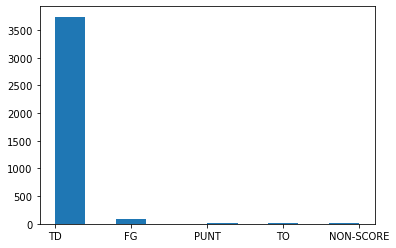

In [21]:
#look at TD classifications
td = drives20.query('reduced_result == "TD"')['preds']

plt.hist(x = td)

(array([714.,   0.,  58.,   0.,   0., 186.,   0., 231.,   0.,  23.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

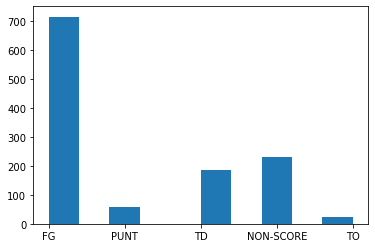

In [22]:
#look at FG classifications
fg = drives20.query('reduced_result == "FG"')['preds']

plt.hist(x = fg)

In [23]:
drives20.query('offense == "BYU"')

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,...,end_ytg,num_plays,score,yards_gained,game_id,ppa_per_play,sr,ppa_sr,reduced_result,preds
1015,4012098182,BYU,North Alabama,2,1,12,8,20,80,TD,...,0,6,True,80,401209818,1.064343,0.666667,0.666667,TD,TD
1017,4012098184,BYU,North Alabama,4,1,7,31,19,81,TD,...,0,8,True,81,401209818,0.905428,0.666667,0.666667,TD,TD
1019,4012098186,BYU,North Alabama,6,1,1,36,14,86,TD,...,0,10,True,86,401209818,0.434091,0.692308,0.461538,TD,TD
1021,4012098188,BYU,North Alabama,8,2,7,50,38,62,TD,...,0,3,True,62,401209818,1.651001,0.666667,0.666667,TD,TD
1023,40120981810,BYU,North Alabama,10,2,4,50,94,6,TD,...,0,4,True,6,401209818,0.513122,0.500000,0.500000,TD,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12524,40125613715,BYU,UCF,15,3,13,56,50,50,TD,...,0,2,True,50,401256137,1.920706,1.000000,1.000000,TD,TD
12526,40125613717,BYU,UCF,17,3,12,42,33,67,TD,...,0,8,True,67,401256137,0.593224,0.666667,0.555556,TD,TD
12528,40125613719,BYU,UCF,19,3,6,44,35,65,DOWNS,...,38,7,False,33,401256137,-0.110582,0.375000,0.375000,NON-SCORE,NON-SCORE
12530,40125613721,BYU,UCF,21,3,0,5,25,75,PUNT,...,65,5,False,10,401256137,-0.489597,0.166667,0.333333,PUNT,PUNT


#### Change results and preds into numeric values -- find who under/over acheived

In [24]:
drives20['actual_points'] = np.where(drives20['reduced_result'] == "TD", 7, 
                             np.where(drives20['reduced_result'] == "FG", 3, 0))
drives20['predicted_points'] = np.where(drives20['preds'] == "TD", 7, 
                             np.where(drives20['preds'] == "FG", 3, 0))

In [25]:
points_per_drive = drives20.groupby('offense').agg(actual_avg = ('actual_points', 'mean'), actual_total = ('actual_points', 'sum'), pred_avg = ('predicted_points', 'mean'), pred_total = ('predicted_points', 'sum'), num_drives = ('drive_id', 'count')).sort_values('pred_avg', ascending = False).reset_index().query('num_drives > 35')

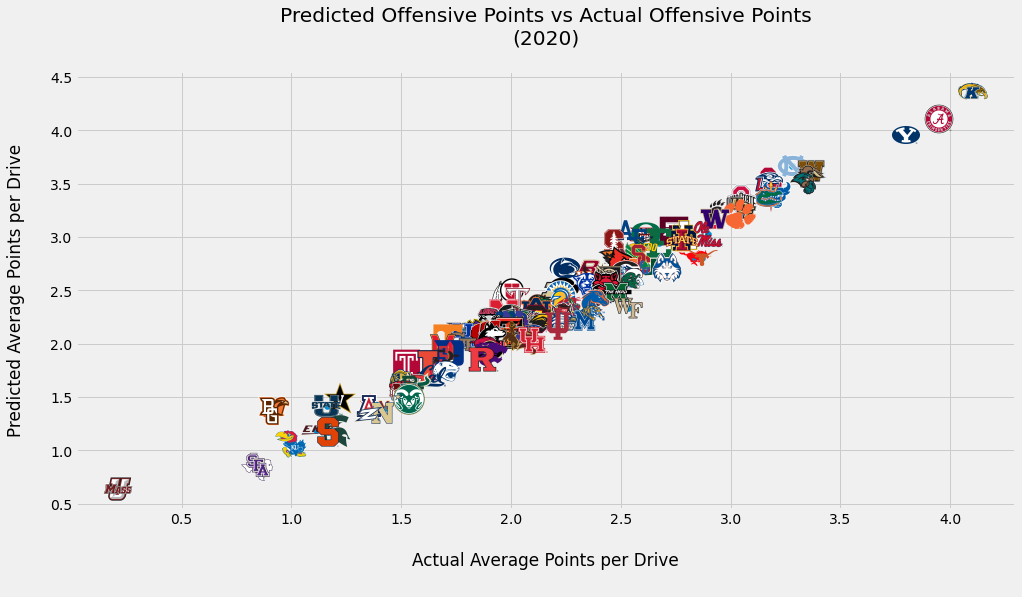

In [26]:
### G R A P H   S T Y L E
plt.style.use('fivethirtyeight')

#Sizing
plt.rcParams["figure.figsize"] = [15, 7.5]

#define function to get paths to logos (in logos file in working directory)
def getImage(path):
    return OffsetImage(plt.imread("./logos/{0}.png".format(path)))

#get team names to put into file path later
paths = points_per_drive['offense']

x = points_per_drive['actual_avg']
y = points_per_drive['pred_avg']

#instantiate plot
fig, ax = plt.subplots()
ax.scatter(x, y) 

# Cycle through each point and add an image annotation
for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Define labels and title
plt.title("Predicted Offensive Points vs Actual Offensive Points\n(2020)\n")
plt.xlabel('\nActual Average Points per Drive\n')
plt.ylabel('Predicted Average Points per Drive\n')
plt.show()

In [27]:
#look at over and under acheivers -- could use prediction intervals and see who is outside the prediction intervals

## Look at Predictions on a Game Level -- Who Should Have Won on Average?

In [28]:
#define function to create in-game graphs

def create_graph(drives = drives20, game_id = 401247295, color1 = "black", color2 = "slategray"):
    game_drives = drives.query('game_id == @game_id')

    team_one = game_drives.offense.unique()[0]
    team_two = game_drives.offense.unique()[1]

    team_one_drives = game_drives.query('offense == @team_one')
    team_two_drives = game_drives.query('offense == @team_two')

    x1 = team_one_drives.drive_number
    x2 = team_two_drives.drive_number
    y1 = team_one_drives.predicted_points.cumsum()
    y2 = team_two_drives.predicted_points.cumsum()

    path1 = pd.Series(team_one).repeat(len(x1))
    path2 = pd.Series(team_two).repeat(len(x1))

    #instantiate plot
    fig, ax = plt.subplots()
    ax.plot(x1, y1, color = color1)
    ax.plot(x2, y2, color = color2)

    # Cycle through each point and add an image annotation
    for x0, y0, path in zip(x1, y1, path1):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    for x0, y0, path in zip(x2, y2, path2):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    
    #paste title text together
    title = ["Predicted", "Points", "per", "Drive: ", team_one, "vs.", team_two]
    
    #add labels to plot
    plt.title(" ".join(title))
    plt.xlabel("Drive Number")
    plt.ylabel("Predicted Points")
    
    #return plot
    return(plt.show())

## Penn State @ Indiana (2020)
### Actual Score: Penn State   35  -  36   Indiana

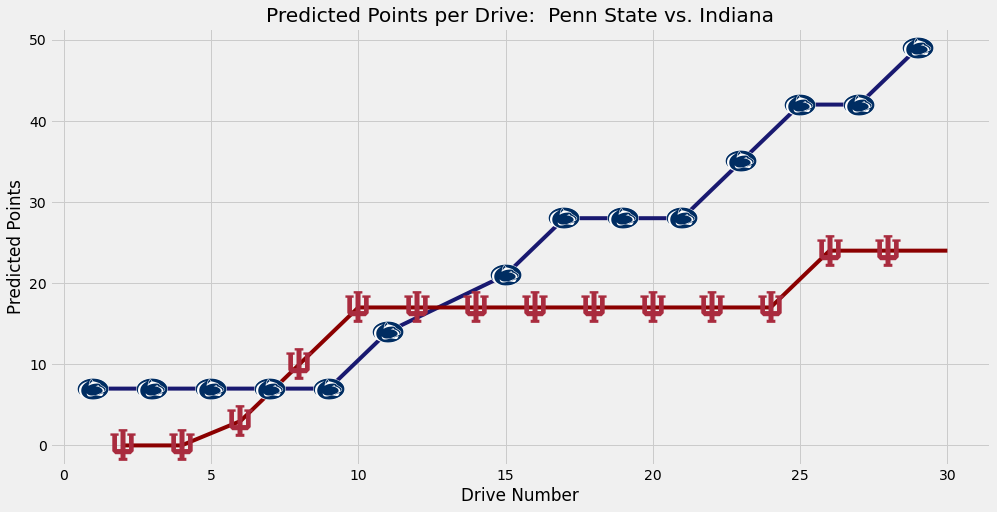

In [29]:
create_graph(drives = drives20, game_id = 401247295, color1 = "midnightblue", color2 = "darkred")

## BYU @ Coastal Carolina (2020)
### Actual Score: BYU   17  -  22   Coastal Carolina

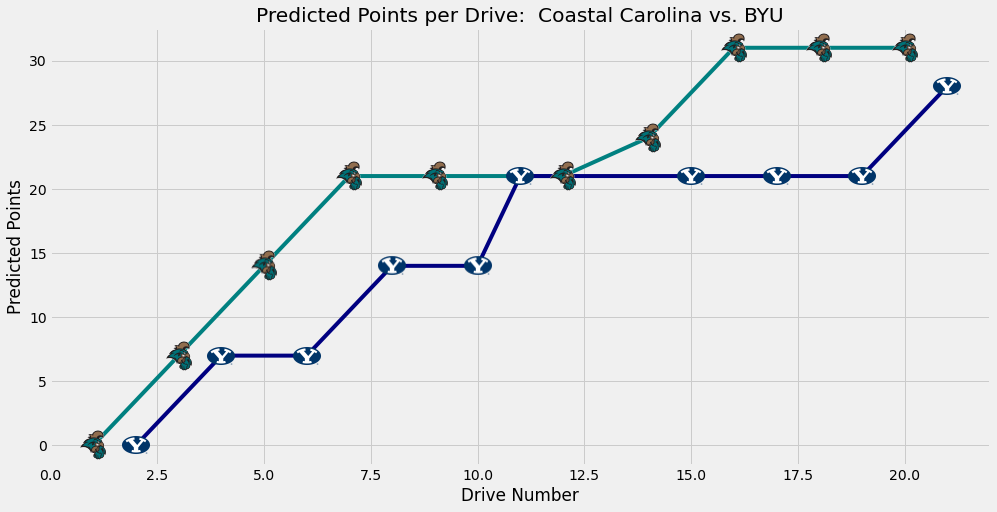

In [30]:
create_graph(drives = drives20, game_id = 401237514, color1 = "teal", color2 = "navy")

## BYU @ Utah (2018)
### Actual Score: BYU   27  -  35   Utah

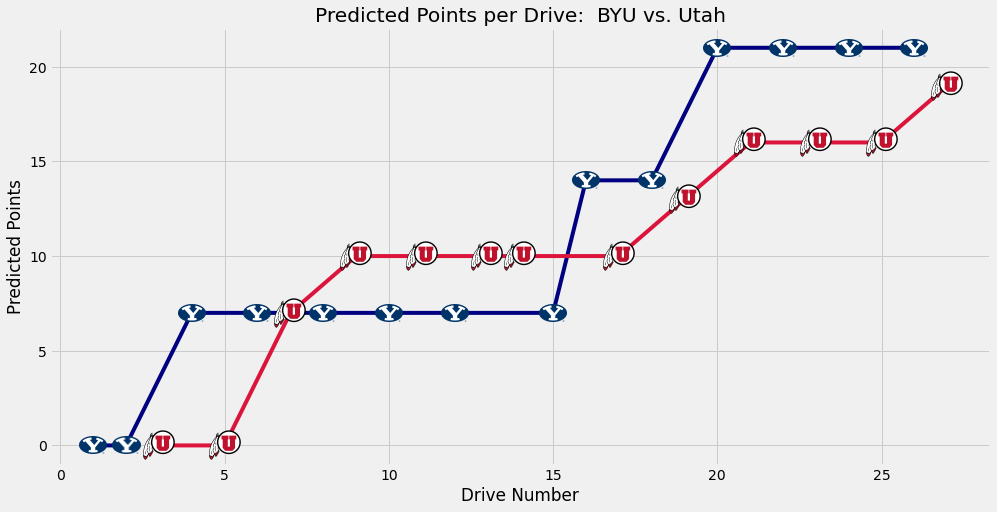

In [31]:
create_graph(drives = drives18, game_id = 401012802, color1 = "navy", color2 = "crimson")

## BYU vs UTSA (2020)
### Actual Score: BYU   27  -  20   UTSA

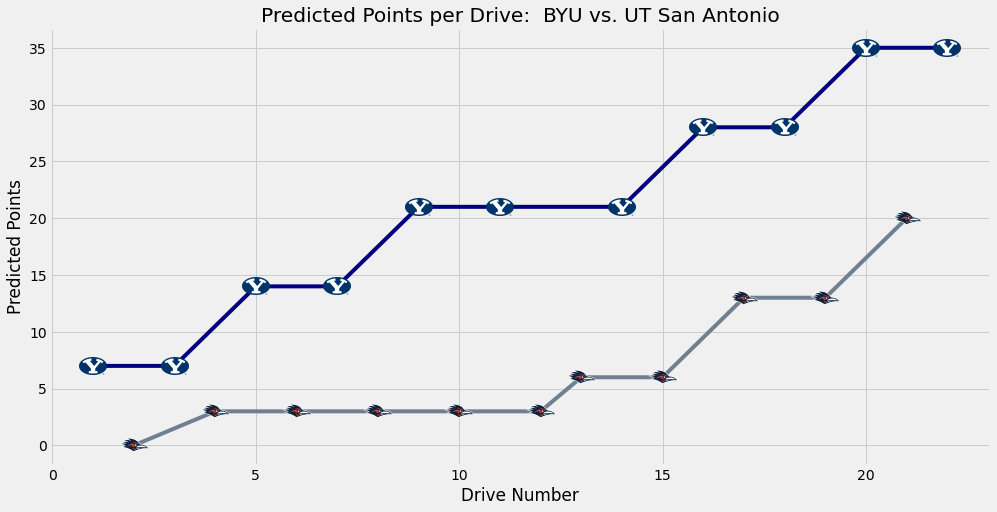

In [32]:
create_graph(game_id = 401240997, color1 = "navy")

## Clemson @ Notre Dame (2020)
### Actual Score: Clemson   40  -  47   Notre Dame

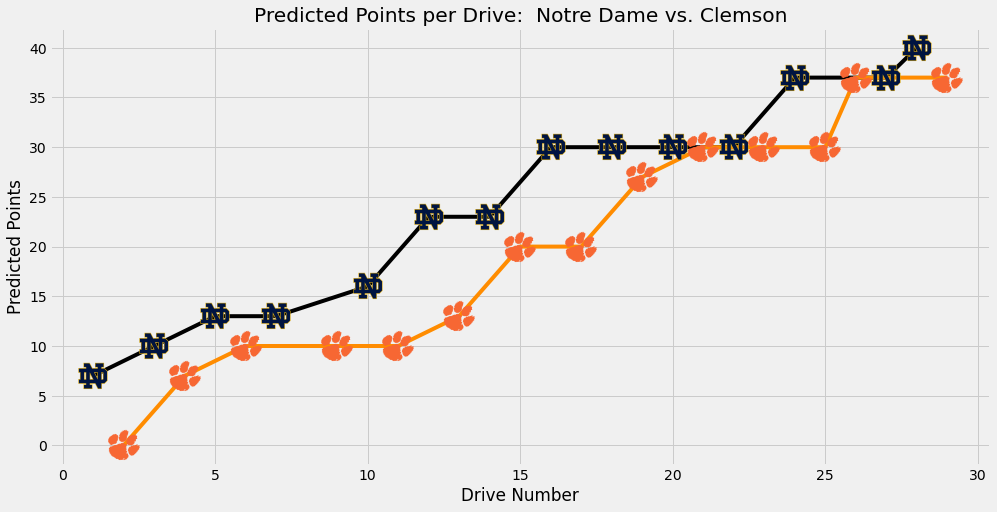

In [33]:
create_graph(game_id = 401234632, color2 = "darkorange")